## Optimized Machine Learning Pipeline
### Data Preprocessing and Integration
### Column Standardization

In [33]:
import pandas as pd
import numpy as np

def standardize_columns(df):
    # Debug: Print original columns
    print("Original columns:", df.columns.tolist())
    
    column_map = {
        r'(?i)cases reported during the year': 'Cases_Reported',
        r'(?i)chargesheeting rate': 'Chargesheeting_Rate',
        r'(?i)pendency percentage': 'Pendency_Percent',
        r'(?i)crime head': 'Crime_Type'
    }
    
    df.columns = df.columns.str.strip()
    
    # Debug: Print columns after stripping
    print("Columns after stripping:", df.columns.tolist())
    
    # Explicitly map columns that match our patterns
    for pattern, new_name in column_map.items():
        for col in df.columns:
            if pd.Series([col]).str.contains(pattern, regex=True).iloc[0]:
                df = df.rename(columns={col: new_name})
    
    df.columns = df.columns.str.replace(' ', '_')
    
    # Debug: Print final columns
    print("Final columns:", df.columns.tolist())
    return df

# Load all datasets
years = [2016, 2018, 2019, 2020, 2021]
datasets = {}

In [34]:
# Load each dataset separately with error handling
for year in years:
    try:
        file_path = f'DATASET_{year}.csv'
        print(f"Loading {file_path}...")
        df = pd.read_csv(file_path)
        print(f"Loaded {file_path} with shape: {df.shape}")
        datasets[year] = standardize_columns(df)
    except Exception as e:
        print(f"Error loading dataset for year {year}: {e}")

Loading DATASET_2016.csv...
Loaded DATASET_2016.csv with shape: (30, 19)
Original columns: ['S. No. (Col.1)', 'Category (Col.2)', 'Crime Head ', 'Cases Pending Investigation from Previous Year (Col.4)', 'Cases Reported during the Year ', 'Total Cases for Investigation (Col.6) = (Col. 4+5)', 'Cases Withdrawn by the Govt during Investigation (Col.7)', 'Cases transferred to other Police Station or Magistrate (Col.8)', 'Cases not Investigated U/S 157(1) (b) of Cr.PC (Col.9)', 'Final Report - True but Insufficient Evidence (Col.10)', 'Final Report - False (Col.11)', 'Final Report - Mistake of Fact (Col.12)', 'Final Report - Non-Cognizable (Col.13)', 'Final Report - Total (Col.14) = (Col.10+ Col.11 +Col.12+ Col.13)', 'Cases in which Chargesheets were Submitted (Col.15)', 'Total Cases Disposed off by Police (Col.16) = (Col.8+ Col.9+ Col.14+ Col.15)', 'Cases Pending Investigation at the End of the Year (Col.17) = (Col. 6 - (Col.7+ Col.16))', 'Chargesheeting Rate ', 'Pendency Percentage ']
Colu

### Temporal Alignment

In [35]:
COMMON_FEATURES = [
    'Year',
    'Crime_Type',
    'Cases_Reported',
    'Chargesheeting_Rate',
    'Pendency_Percent'
]

def align_datasets(df, year):
    # Debug information
    print(f"Aligning dataset for year {year}")
    print(f"Available columns: {df.columns.tolist()}")
    
    result_df = pd.DataFrame()
    result_df['Year'] = [year] * len(df)
    
    # Map existing columns or create placeholders
    for col in COMMON_FEATURES[1:]:  # Skip Year
        if col in df.columns:
            result_df[col] = df[col].values
        else:
            print(f"Column {col} not found in dataset for year {year}")
            # Try to find appropriate columns based on dataset structure
            if col == 'Crime_Type' and 'Category_(Col.2)' in df.columns:
                result_df[col] = df['Category_(Col.2)'].values
            elif col == 'Cases_Reported' and 'Cases_Reported_during_the_Year' in df.columns:
                result_df[col] = df['Cases_Reported_during_the_Year'].values
            else:
                result_df[col] = np.nan
            
    # Add temporal identifiers
    result_df['Decade'] = (year // 10) * 10
    result_df['Post_2018'] = int(year > 2018)
    
    return result_df

# Process all years with error handling
aligned_data = []

for year in years:
    if year in datasets:
        try:
            aligned_df = align_datasets(datasets[year], year)
            print(f"Aligned data for {year} has shape: {aligned_df.shape}")
            aligned_data.append(aligned_df)
        except Exception as e:
            print(f"Error aligning dataset for year {year}: {e}")
    else:
        print(f"Dataset for year {year} not available")

# Only concatenate if we have data
if aligned_data:
    combined_df = pd.concat(aligned_data).reset_index(drop=True)
    print(f"Combined dataframe has shape: {combined_df.shape}")
else:
    print("No aligned data to combine")
    combined_df = pd.DataFrame()

Aligning dataset for year 2016
Available columns: ['S._No._(Col.1)', 'Category_(Col.2)', 'Crime_Type', 'Cases_Pending_Investigation_from_Previous_Year_(Col.4)', 'Cases_Reported', 'Total_Cases_for_Investigation_(Col.6)_=_(Col._4+5)', 'Cases_Withdrawn_by_the_Govt_during_Investigation_(Col.7)', 'Cases_transferred_to_other_Police_Station_or_Magistrate_(Col.8)', 'Cases_not_Investigated_U/S_157(1)_(b)_of_Cr.PC_(Col.9)', 'Final_Report_-_True_but_Insufficient_Evidence_(Col.10)', 'Final_Report_-_False_(Col.11)', 'Final_Report_-_Mistake_of_Fact_(Col.12)', 'Final_Report_-_Non-Cognizable_(Col.13)', 'Final_Report_-_Total_(Col.14)_=_(Col.10+_Col.11_+Col.12+_Col.13)', 'Cases_in_which_Chargesheets_were_Submitted_(Col.15)', 'Total_Cases_Disposed_off_by_Police_(Col.16)_=_(Col.8+_Col.9+_Col.14+_Col.15)', 'Cases_Pending_Investigation_at_the_End_of_the_Year_(Col.17)_=_(Col._6_-_(Col.7+_Col.16))', 'Chargesheeting_Rate', 'Pendency_Percent']
Aligned data for 2016 has shape: (30, 7)
Aligning dataset for year 2

In [36]:
# Check if combined_df is empty before proceeding
if not combined_df.empty:
    crime_mapping = {
        r'(?i)ransom': 'Ransomware',
        r'(?i)debit card|credit card': 'Financial_Fraud',
        r'(?i)social media|fake profile': 'Social_Media_Crimes',
        r'(?i)data theft|privacy': 'Data_Privacy_Violations'
    }
    
    # Ensure Crime_Type column exists and is string type
    if 'Crime_Type' in combined_df.columns:
        combined_df['Crime_Type'] = combined_df['Crime_Type'].astype(str)
        combined_df['Crime_Group'] = 'Other'
        
        for pattern, group in crime_mapping.items():
            mask = combined_df['Crime_Type'].str.contains(pattern, regex=True, na=False)
            combined_df.loc[mask, 'Crime_Group'] = group
    else:
        print("Warning: Crime_Type column not found in combined_df")
        combined_df['Crime_Group'] = 'Unknown'
else:
    print("combined_df is empty, cannot map crime types")

In [37]:
# Temporal rolling features (only if combined_df is not empty)
if not combined_df.empty and 'Crime_Group' in combined_df.columns:
    window_sizes = [2, 3]  # 2-year and 3-year windows
    
    for window in window_sizes:
        combined_df[f'Cases_MA_{window}yr'] = combined_df.groupby('Crime_Group')['Cases_Reported']\
            .transform(lambda x: x.rolling(window, min_periods=1).mean())
        
        combined_df[f'ChargeRate_MA_{window}yr'] = combined_df.groupby('Crime_Group')['Chargesheeting_Rate']\
            .transform(lambda x: x.rolling(window, min_periods=1).mean())
else:
    print("Cannot create rolling features: combined_df is empty or missing Crime_Group column")

In [38]:
# Create shifted target for prediction (only if combined_df is not empty)
if not combined_df.empty and 'Crime_Group' in combined_df.columns and 'Chargesheeting_Rate' in combined_df.columns:
    combined_df['Target_ChargeRate'] = combined_df.groupby('Crime_Group')['Chargesheeting_Rate']\
        .shift(-1)
    
    # Handle remaining NaNs
    combined_df = combined_df.dropna(subset=['Target_ChargeRate'])
    print(f"Final combined_df shape after dropna: {combined_df.shape}")
    print(combined_df.head())
else:
    print("Cannot create target variable: combined_df is empty or missing required columns")

Final combined_df shape after dropna: (213, 13)
   Year                                         Crime_Type  Cases_Reported  \
0  2016                Tampering computer source documents              78   
1  2016  Computer Related Offences (Section 66 and Sect...            6818   
2  2016         Computer Related Offences-Under Section 66            3321   
3  2016        Computer Related Offences-Under Section 66B             196   
4  2016        Computer Related Offences-Under Section 66C            1545   

   Chargesheeting_Rate  Pendency_Percent  Decade  Post_2018 Crime_Group  \
0                 39.5              49.7    2010          0       Other   
1                 37.1              59.7    2010          0       Other   
2                 43.3              54.6    2010          0       Other   
3                 47.3              64.6    2010          0       Other   
4                 30.5              68.1    2010          0       Other   

   Cases_MA_2yr  ChargeRate_MA_2

## Model Development


In [39]:
# Only proceed with model development if we have data
if not combined_df.empty:
    print("combined_df.shape:", combined_df.shape)
    print("combined_df.columns:", combined_df.columns.tolist())
    print("first few rows:\n", combined_df.head())
    
    from sklearn.model_selection import train_test_split
    
    # Use most recent 20% for testing
    X = combined_df.drop(['Target_ChargeRate', 'Crime_Type'], axis=1)
    y = combined_df['Target_ChargeRate']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )
    print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
else:
    print("Model development skipped: combined_df is empty")

combined_df.shape: (213, 13)
combined_df.columns: ['Year', 'Crime_Type', 'Cases_Reported', 'Chargesheeting_Rate', 'Pendency_Percent', 'Decade', 'Post_2018', 'Crime_Group', 'Cases_MA_2yr', 'ChargeRate_MA_2yr', 'Cases_MA_3yr', 'ChargeRate_MA_3yr', 'Target_ChargeRate']
first few rows:
    Year                                         Crime_Type  Cases_Reported  \
0  2016                Tampering computer source documents              78   
1  2016  Computer Related Offences (Section 66 and Sect...            6818   
2  2016         Computer Related Offences-Under Section 66            3321   
3  2016        Computer Related Offences-Under Section 66B             196   
4  2016        Computer Related Offences-Under Section 66C            1545   

   Chargesheeting_Rate  Pendency_Percent  Decade  Post_2018 Crime_Group  \
0                 39.5              49.7    2010          0       Other   
1                 37.1              59.7    2010          0       Other   
2                 43.3

In [40]:
# Install xgboost if not already installed
%pip install xgboost

from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np

if not combined_df.empty:
    # Identify categorical and numerical columns
    categorical_cols = ['Crime_Group']
    numerical_cols = [col for col in X.columns if col not in categorical_cols]
    
    print(f"Categorical columns: {categorical_cols}")
    print(f"Numerical columns: {numerical_cols}")
    
    # Create preprocessing pipeline with one-hot encoding for categorical features
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', RobustScaler(), numerical_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ]
    )
    
    # Create and fit the model
    model = make_pipeline(
        preprocessor,
        HistGradientBoostingRegressor(
            max_iter=200,
            learning_rate=0.05,
            max_depth=5
        )
    )
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    from sklearn.metrics import mean_absolute_error, r2_score
    
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"R2 Score: {r2:.2f}")
else:
    print("Combined dataframe is empty, cannot train model")

Note: you may need to restart the kernel to use updated packages.
Categorical columns: ['Crime_Group']
Numerical columns: ['Year', 'Cases_Reported', 'Chargesheeting_Rate', 'Pendency_Percent', 'Decade', 'Post_2018', 'Cases_MA_2yr', 'ChargeRate_MA_2yr', 'Cases_MA_3yr', 'ChargeRate_MA_3yr']
Mean Absolute Error: 23.13
R2 Score: -0.34



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [41]:
# Alternative approach using sklearn's newer categorical feature handling
# This works with newer versions of scikit-learn (1.2+)
if not combined_df.empty:
    # Create a copy of the data
    X_train_cat = X_train.copy()
    X_test_cat = X_test.copy()
    
    # Convert categorical columns to 'category' dtype
    X_train_cat['Crime_Group'] = X_train_cat['Crime_Group'].astype('category')
    X_test_cat['Crime_Group'] = X_test_cat['Crime_Group'].astype('category')
    X_train_cat['Decade'] = X_train_cat['Decade'].astype('category')
    X_test_cat['Decade'] = X_test_cat['Decade'].astype('category')
    X_train_cat['Post_2018'] = X_train_cat['Post_2018'].astype('category')
    X_test_cat['Post_2018'] = X_test_cat['Post_2018'].astype('category')
    
    # Get categorical feature indices
    categorical_mask = [X_train_cat.dtypes[col].name == 'category' for col in X_train_cat.columns]
    
    # Create and fit the model with proper categorical feature specification
    model2 = make_pipeline(
        RobustScaler(),
        HistGradientBoostingRegressor(
            max_iter=200,
            learning_rate=0.05,
            max_depth=5,
            categorical_features=categorical_mask
        )
    )
    
    # Fit the model
    try:
        model2.fit(X_train_cat, y_train)
        print("Alternative model training successful")
        
        # Make predictions
        y_pred2 = model2.predict(X_test_cat)
        
        # Evaluate
        mae2 = mean_absolute_error(y_test, y_pred2)
        r2_2 = r2_score(y_test, y_pred2)
        
        print(f"Alternative Model MAE: {mae2:.2f}")
        print(f"Alternative Model R2: {r2_2:.2f}")
    except Exception as e:
        print(f"Error with alternative model: {e}")

Error with alternative model: could not convert string to float: 'Other'


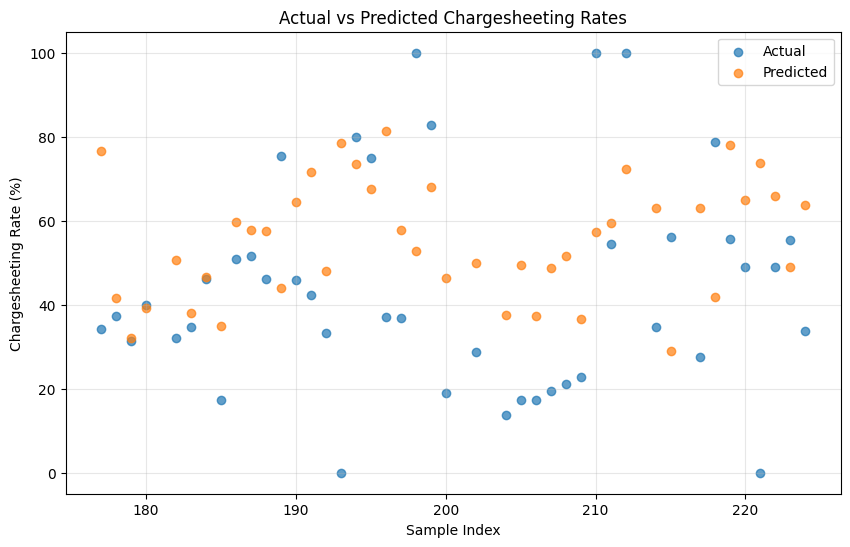

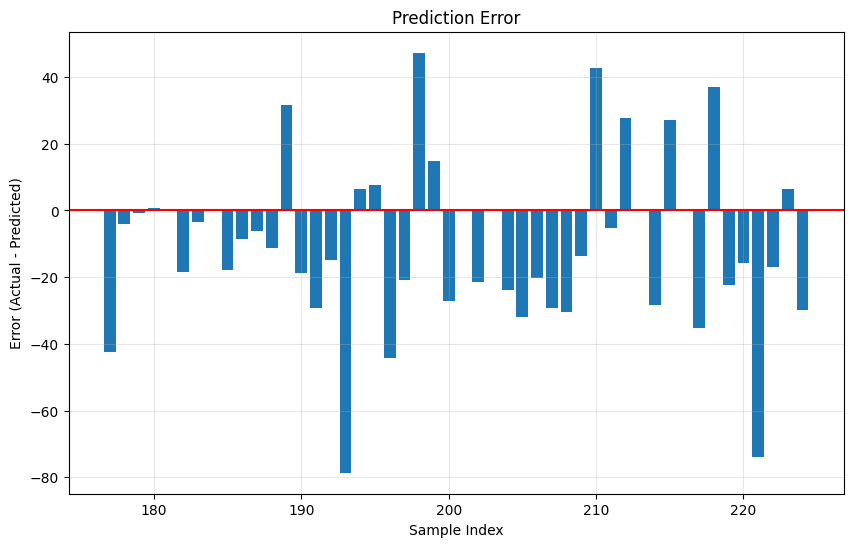

In [42]:
# Visualize model performance
import matplotlib.pyplot as plt
import pandas as pd

if 'y_pred' in locals():
    # Create a dataframe for comparison
    results_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred
    })
    
    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(results_df.index, results_df['Actual'], label='Actual', alpha=0.7)
    plt.scatter(results_df.index, results_df['Predicted'], label='Predicted', alpha=0.7)
    plt.title('Actual vs Predicted Chargesheeting Rates')
    plt.xlabel('Sample Index')
    plt.ylabel('Chargesheeting Rate (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Plot prediction error
    results_df['Error'] = results_df['Actual'] - results_df['Predicted']
    
    plt.figure(figsize=(10, 6))
    plt.bar(results_df.index, results_df['Error'])
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title('Prediction Error')
    plt.xlabel('Sample Index')
    plt.ylabel('Error (Actual - Predicted)')
    plt.grid(True, alpha=0.3)
    plt.show()